# Compare the difference in elevation between DEM and Icesat-2 Data

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

from shapely.geometry import Polygon, Point
import hvplot
import geoviews as gv

import xarray as xr

import rasterio as rio
import hvplot.pandas
import hvplot.xarray

In [3]:
# strip = 'GE01_20181022_1050010012B24800_1050010012B24A00_2m_lsf'
strip = 'WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf'

# icesat2_path = f'D:/icesat2/rema/region_03_peninsula_south_2/{strip}'
region = 'region_03_peninsula_south'
icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/{region}/{strip}'
files = os.listdir(f'{icesat2_path}')
outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')
# hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
# csv_files = [f for f in files if f.endswith('.csv')]
shp_files

['processed_ATL06_20181104061356_05590110_002_01.shp',
 'processed_ATL06_20181203044949_10010110_002_01.shp',
 'processed_ATL06_20181026194351_04300112_002_01.shp',
 'processed_ATL06_20181022195209_03690112_002_01.shp',
 'processed_ATL06_20181031062211_04980110_002_01.shp',
 'processed_ATL06_20181120182818_08110112_002_01.shp']

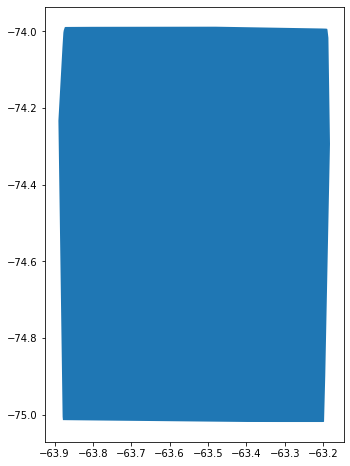

In [4]:
outline.plot()

In [5]:
# Read ATL Shapefile
shp = 'processed_ATL06_20181104061356_05590110_002_01.shp'#'processed_ATL06_20181204184610_10250112_002_01.shp'
gdf = gpd.read_file(f'{icesat2_path}/{shp}')
gdf.head(2)

,t_dt,h_li,q_flag,strip,geometry
0,2018-11-04 06:20:56.921000,3057.212158,1,gt1l,POINT (-63.27671 -74.00674)
1,2018-11-04 06:20:57.005000,3130.900635,1,gt1l,POINT (-63.27952 -74.01204)


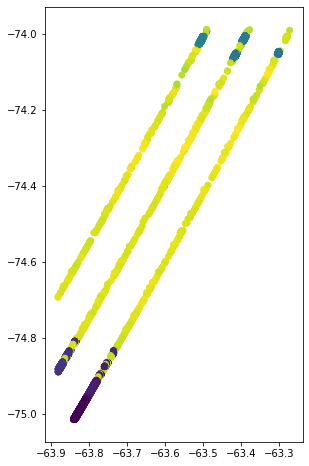

In [6]:
gdf.plot(column='h_li')

In [7]:
gdf.strip.value_counts()

gt1l    865
gt1r    670
gt2l    463
gt2r    403
gt3l    220
gt3r    141
Name: strip, dtype: int64

## Now get the DEM (Rema for example)

In [8]:
dir_prefix = '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf
dem_folder = f'{dir_prefix}/REMA/{region}/strips_unf/2m/{strip}'
# dem_foler = f'D:/REMA/region_03_peninsula_south/strips_unf/2m/{strip}'
tifs = [tif for tif in os.listdir(dem_folder) if tif.endswith('.tif')]
tifs

['WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf_seg1_dem.tif',
 'WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf_seg1_ortho.tif',
 'WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf_seg1_dem_10m.tif',
 'WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf_seg1_dem_browse.tif',
 'WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf_seg1_matchtag.tif',
 'WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf_seg1_bitmask.tif']

In [9]:
# da = xr.open_rasterio(tif, chunks={'x':2**11, 'y':2**11, 'band':8})
# da = xr.open_rasterio(tif, )
da = xr.open_rasterio(f'{dem_folder}/{tifs[0]}', parse_coordinates=True, chunks={'x':2**12, 'y':2**12})
da

<xarray.DataArray (band: 1, y: 34260, x: 55419)>
dask.array<open_rasterio-0f4966240135d56d7e541361d8d02e48<this-array>, shape=(1, 34260, 55419), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 7.894e+05 7.894e+05 7.894e+05 ... 7.209e+05 7.209e+05
  * x        (x) float64 -1.572e+06 -1.572e+06 ... -1.461e+06 -1.461e+06
Attributes:
    transform:      (2.0, 0.0, -1571758.0, 0.0, -2.0, 789374.0)
    crs:            +init=epsg:3031
    res:            (2.0, 2.0)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [10]:
da.crs

'+init=epsg:3031'

In [11]:
# da.data[da.data==0] = pd.NA

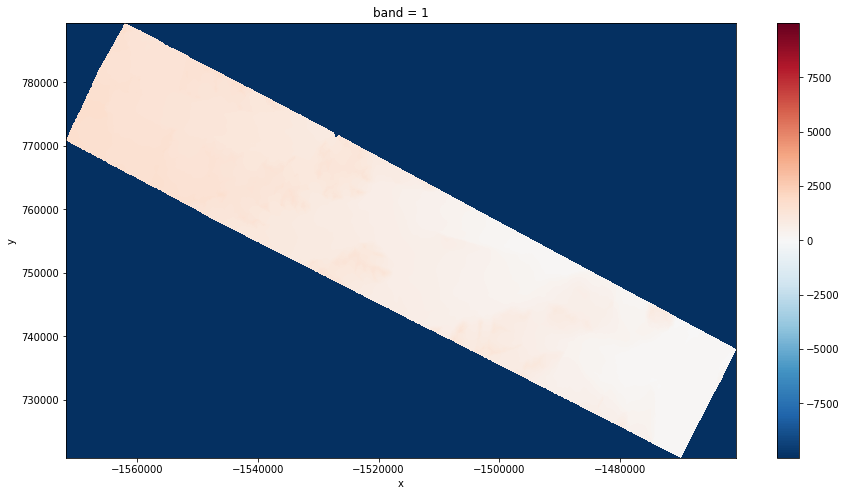

In [12]:
da.sel(band=1).plot.imshow();

In [13]:
da.min()

<xarray.DataArray ()>
dask.array<nanmin-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [17]:
da = xr.open_rasterio(f'{dem_folder}/{tifs[1]}')
da.data = da.data.astype(float)
nodata_value = da.attrs['nodatavals'][0]
da.data[da.data==nodata_value] = np.nan
print(nodata_value)
da

0.0


<xarray.DataArray (band: 1, y: 34260, x: 55419)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 7.894e+05 7.894e+05 7.894e+05 ... 7.209e+05 7.209e+05
  * x        (x) float64 -1.572e+06 -1.572e+06 ... -1.461e+06 -1.461e+06
Attributes:
    transform:      (2.0, 0.0, -1571758.0, 0.0, -2.0, 789374.0)
    crs:            +init=epsg:3031
    res:            (2.0, 2.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

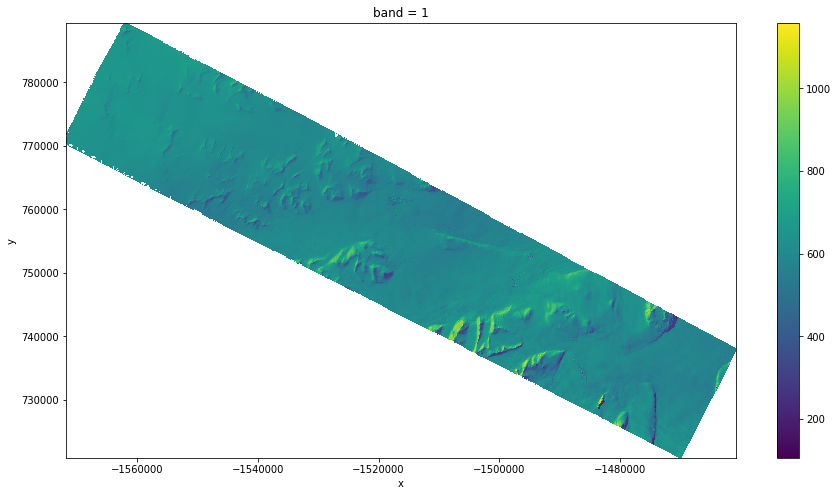

In [18]:
da.sel(band=1).plot.imshow();

In [23]:
da

<xarray.DataArray (band: 1, y: 34260, x: 55419)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 7.894e+05 7.894e+05 7.894e+05 ... 7.209e+05 7.209e+05
  * x        (x) float64 -1.572e+06 -1.572e+06 ... -1.461e+06 -1.461e+06
Attributes:
    transform:      (2.0, 0.0, -1571758.0, 0.0, -2.0, 789374.0)
    crs:            +init=epsg:3031
    res:            (2.0, 2.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

<xarray.DataArray (band: 1, y: 34260, x: 55419)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 7.894e+05 7.894e+05 7.894e+05 ... 7.209e+05 7.209e+05
  * x        (x) float64 -1.572e+06 -1.572e+06 ... -1.461e+06 -1.461e+06
Attributes:
    transform:      (2.0, 0.0, -1571758.0, 0.0, -2.0, 789374.0)
    crs:            +init=epsg:3031
    res:            (2.0, 2.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

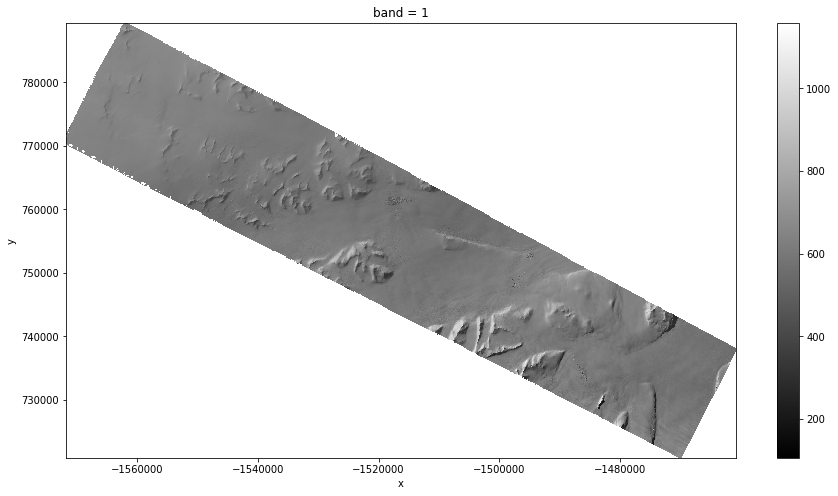

In [25]:
da.sel(band=1).plot.imshow(cmap='gray')
da

In [26]:
da = xr.open_rasterio(f'{dem_foler}/{tifs[-1]}')
da.sel(band=1).plot.imshow(robust=True)
da

NameError: name 'dem_foler' is not defined

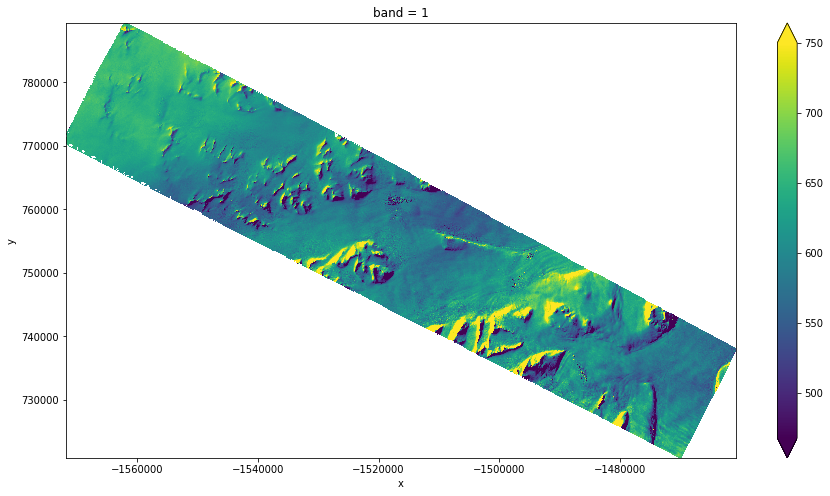

In [27]:
da.sel(band=1).plot.imshow(robust=True)

In [26]:
# import regionmask

In [97]:
da = xr.open_rasterio(f'{dem_foler}/{tifs[-1]}')
da.attrs

{'transform': (2.0, 0.0, -1906092.0, 0.0, -2.0, 386914.0),
 'crs': '+init=epsg:3031',
 'res': (2.0, 2.0),
 'is_tiled': 1,
 'nodatavals': (0.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area'}

In [99]:
da.data = da.data.astype(np.float32)

In [100]:
nodata_value = da.attrs['nodatavals'][0]
da.data[da.data==nodata_value] = np.nan
print(nodata_value)
da

0.0


<xarray.DataArray (band: 1, y: 9456, x: 5730)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 3.869e+05 3.869e+05 3.869e+05 ... 3.68e+05 3.68e+05
  * x        (x) float64 -1.906e+06 -1.906e+06 ... -1.895e+06 -1.895e+06
Attributes:
    transform:      (2.0, 0.0, -1906092.0, 0.0, -2.0, 386914.0)
    crs:            +init=epsg:3031
    res:            (2.0, 2.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

### Try some other approach to extract point values from DEM, using georasters/rasterio etc


In [28]:
import georasters as grs

In [30]:
dem = grs.from_file(f'{dem_folder}/{tifs[1]}')
dem

In [33]:
tifs[1]

'WV01_20181105_102001007A1DE300_102001007B896A00_2m_lsf_seg1_ortho.tif'

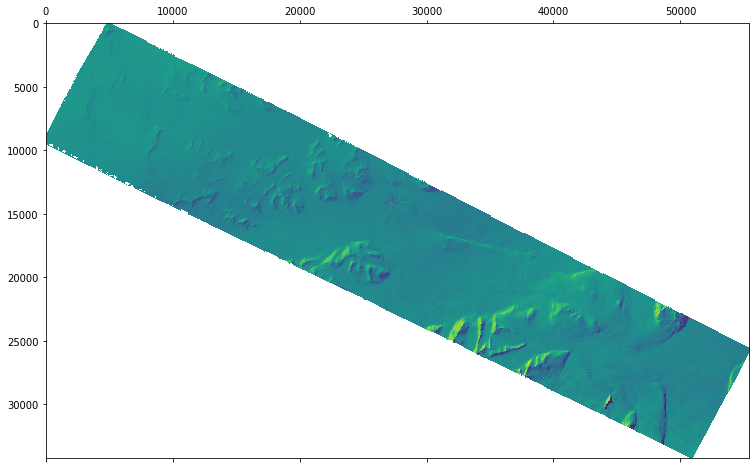

In [31]:
# Get info on raster (NDV=No data value)
# NDV, xsize, ysize, GeoT, Projection, DataType = grs.get_geo_info('gis_challenge/n29_w095_1arc_v3.tif') #has to be file
dem.plot(); #, plt.colorbar(); not working

In [14]:
# gdf.plot()

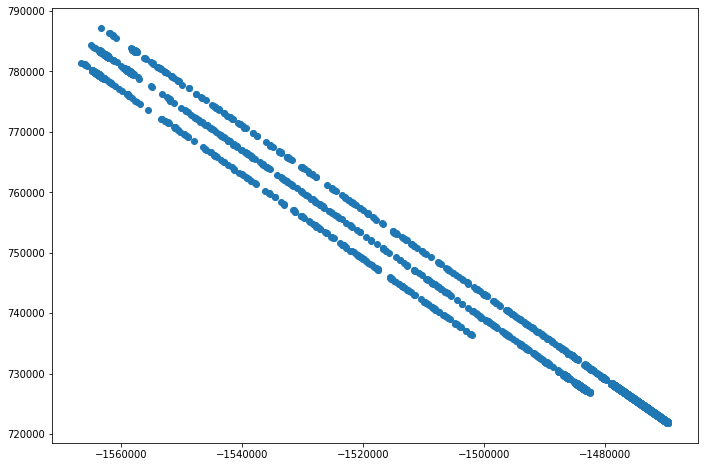

In [28]:
# Reproject the shapefile to that of REMA
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# proj4 = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #arcticDEM
# gdf = gdf.to_crs({'init': 'epsg:4326'}) #change to lat/longitude
gdf = gdf.to_crs(proj4)
gdf.plot()

In [29]:
# print(dem.projection.ExportToPrettyWkt())

In [30]:
# Initilize dem elevlation
gdf['dem'] = 0.

In [31]:
def getPixVal(geom):
    #dem.map_pixel(x, y)
    coords = geom.coords[0]
    x, y = coords
    return(dem.map_pixel(x, y))

In [32]:
gdf['dem'] = gdf.geometry.apply(getPixVal)

In [218]:
gdf = gdf.iloc[1:]

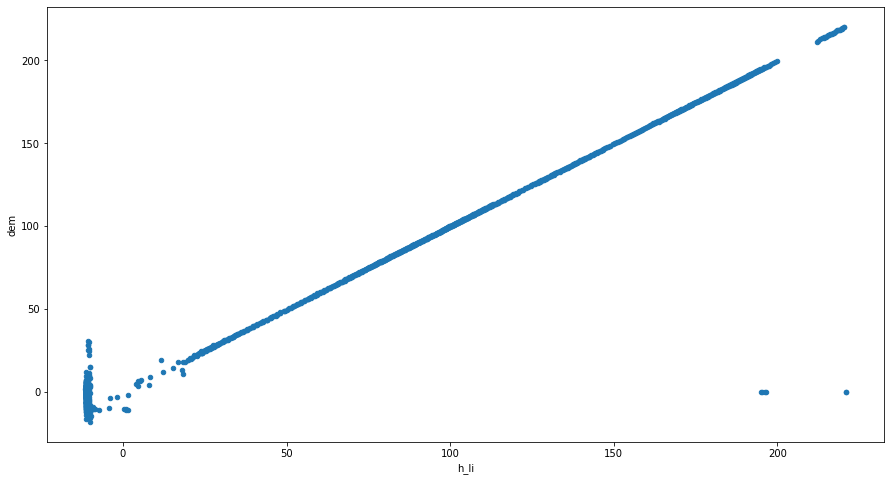

In [22]:
gdf[['h_li', 'dem']].plot(kind='scatter', x=0, y=1);

In [23]:
# gdf.geometry.apply(lambda x: x.coords[0])


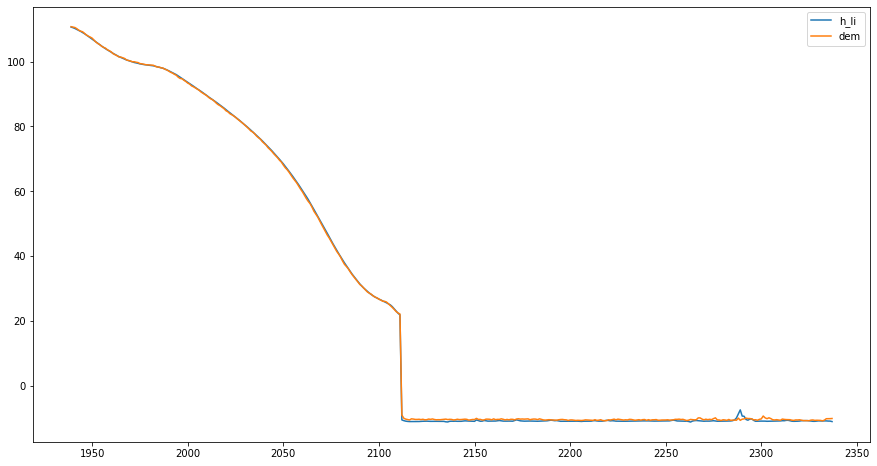

In [33]:
strip = 'gt3r'
gdf[gdf.strip==strip][['h_li', 'dem']].plot()